In [1]:
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torchvision
import pathlib
import matplotlib.pyplot as plt

In [2]:
# Defining the transformation function
train_transformer = transforms.Compose([
                                    transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5], [0.5])])

val_test_transformer = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5], [0.5])])

In [3]:
train_path = "D:/X-ray/input/Training"
val_path = "D:/X-ray/input/Validation"
test_path = "D:/X-ray/input/Testing"

train_loader = DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform = train_transformer),
    batch_size = 64, shuffle = True, num_workers = 4
)
val_loader = DataLoader(
    torchvision.datasets.ImageFolder(val_path, transform = val_test_transformer),
    batch_size = 32, shuffle = False , num_workers = 4
)
test_loader = DataLoader(
    torchvision.datasets.ImageFolder(test_path, transform = val_test_transformer),
    batch_size = 32, shuffle = False , num_workers = 4
)

# Labels
root = pathlib.Path(train_path)
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['Not Pneumonic', 'Pneumonic']


In [18]:
# Model architecture
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
loss_function = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-6)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [7]:
#Calculating size of training and testing images
train_count = len(glob.glob(train_path + '/**/*.jpg'))
val_count = len(glob.glob(val_path + '/**/*.jpg'))
test_count = len(glob.glob(test_path + '/**/*.jpg'))
print(train_count,val_count,test_count)

14589 1801 1801


cuda
Epoch: 0 Train Loss: 0.6750572163317233 Train Accuracy: 0.5838645554870108 Validation Accuracy: 0.606329816768462
Epoch: 1 Train Loss: 0.6447196464197346 Train Accuracy: 0.6374665844129138 Validation Accuracy: 0.6535258189894503
Epoch: 2 Train Loss: 0.6206671676386358 Train Accuracy: 0.6705737199259716 Validation Accuracy: 0.6818434203220433
Epoch: 3 Train Loss: 0.5991411125923871 Train Accuracy: 0.6977860031530605 Validation Accuracy: 0.7179344808439756
Epoch: 4 Train Loss: 0.5840222731399131 Train Accuracy: 0.7123860442799369 Validation Accuracy: 0.7307051637978901
Epoch: 5 Train Loss: 0.5713602781124182 Train Accuracy: 0.7214339570909589 Validation Accuracy: 0.7323709050527485
Epoch: 6 Train Loss: 0.5602640086747039 Train Accuracy: 0.7341147439851943 Validation Accuracy: 0.747917823431427
Epoch: 7 Train Loss: 0.552094665561728 Train Accuracy: 0.7371307149222016 Validation Accuracy: 0.7518045530260966
Epoch: 8 Train Loss: 0.5442325628901191 Train Accuracy: 0.7404894098293234 Val

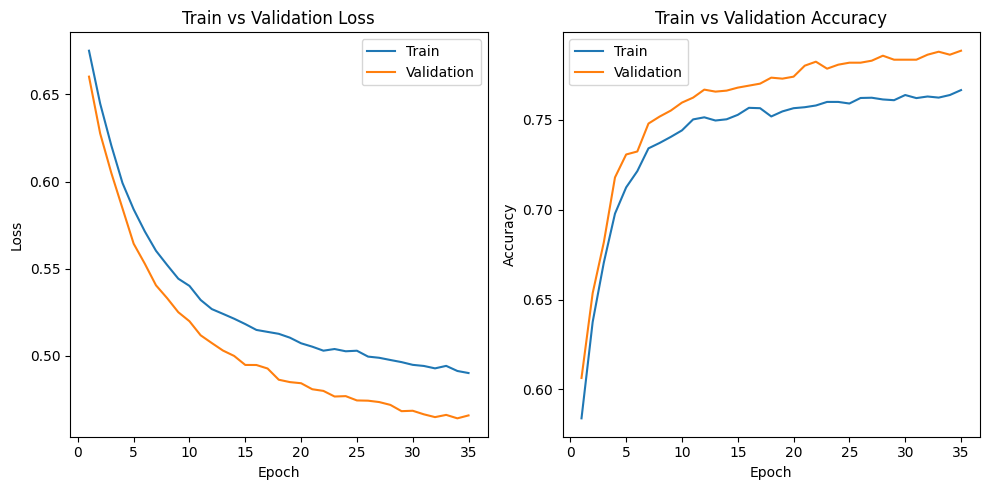

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

best_accuracy = 0.0
num_epochs = 35

# For plotting the loss and accuracy with epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Evaluation and training on training dataset
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device).type(torch.float)  # Ensure labels are float type
        labels = labels.to(device)
        optimizer.zero_grad()
    
        outputs = model(images)
        outputs = torch.sigmoid(outputs).squeeze()  # Apply sigmoid activation function
        
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        predicted = (outputs >= 0.5).to(torch.float)  # Convert probabilities to binary predictions
        train_accuracy += torch.sum(predicted == labels).item()

    train_accuracy = train_accuracy / len(train_loader.dataset)
    train_loss = train_loss / len(train_loader.dataset)

    # Evaluation on validation dataset
    model.eval()  # Set the model to evaluation mode

    val_accuracy = 0.0
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation during validation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).type(torch.float)  # Ensure labels are float type
            labels = labels.to(device)
            
            outputs = model(images)
            outputs = torch.sigmoid(outputs).squeeze()  # Apply sigmoid activation function
            
            loss = loss_function(outputs, labels)
            val_loss += loss.item() * images.size(0)
    
            predicted = (outputs >= 0.5).to(torch.float)  # Convert probabilities to binary predictions
            val_accuracy += torch.sum(predicted == labels).item()

    val_accuracy = val_accuracy / len(val_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)

    print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(train_loss) + ' Train Accuracy: ' + str(
        train_accuracy) + ' Validation Accuracy: ' + str(val_accuracy))

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Save the best model
    if val_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'cross_model3.pth')
        best_accuracy = val_accuracy

plt.figure(figsize=(10, 5))
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epoch+2), train_losses, label='Train')
plt.plot(range(1, epoch+2), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epoch+2), train_accuracies, label='Train')
plt.plot(range(1, epoch+2), val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [4]:
import torchmetrics

model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1)
model.load_state_dict(torch.load("C:/Users/ACER/Machine Learning/cross_model1.pth", map_location = torch.device('cpu')))
model.eval()
device = 'cpu'
# Instantiate metrics
confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=2, task="binary").to(device)

# Iterate through validation dataset
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(images)

    # Compute predictions
    preds = torch.sigmoid(outputs)

    # Convert predictions to binary (0 or 1)
    binary_preds = torch.round(preds).squeeze().long()

    # Update confusion matrix
    confusion_matrix.update(binary_preds, labels)

# Print confusion matrix
print(f"Confusion Matrix:\n{confusion_matrix.compute()}")


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Confusion Matrix:
tensor([[791, 209],
        [191, 610]])


In [5]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [1]:
# Accuracy precision recall

# Our confusion matrix
confusion_matrix = [[791,209],
                    [191,610]]


def calculate_accuracy(confusion_matrix):
    TN, FP = confusion_matrix[0]
    FN, TP = confusion_matrix[1]
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    return accuracy

def calculate_recall(confusion_matrix):
    TN, FP = confusion_matrix[0]
    FN, TP = confusion_matrix[1]
    recall = TP / (TP + FN)
    return recall

def calculate_precision(confusion_matrix):
    TN, FP = confusion_matrix[0]
    FN, TP = confusion_matrix[1]
    precision = TP / (TP + FP)
    return precision

def get_f1(precision, recall):
    f1_val = 2*(precision*recall)/(precision+recall)
    return f1_val

# Respective evaluation criteria

recall = calculate_recall(confusion_matrix)
precision = calculate_precision(confusion_matrix)
accuracy = calculate_accuracy(confusion_matrix)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 score:",get_f1(precision,recall))

Accuracy: 0.7779011660188784
Recall: 0.7615480649188514
Precision: 0.7448107448107448
F1 score: 0.7530864197530864
